In [1]:
import numpy as np
from matplotlib import pyplot as plt
from scipy.special import expit as sigmoid

from time import time
from time import sleep


In [2]:
#function to do nothing -- helps clean code use din debugging
def silent(a = None):
    return

def shuffle_together(v_1, v_2):
    assert len(v_1) == len(v_2), "vectors different length"
    
    perm = np.random.permutation(len(v_1))
    return v_1[perm], v_2[perm]


In [3]:
class connected_layer:
    def __init__(self, num_neurons, prev_neurons):
        
        #number of neurons in layer and previous layer
        self.size = num_neurons 
        self.prev_size = prev_neurons 
        
        #weight matrix and bias matrix initialization
        
        #-must randomize weight matrix so that gradient isn't same for all neurons
        #--because gradient of neuron w respect to previous neuron is just associated weight
        self.weight_mat = np.random.uniform(-2, 2, (num_neurons, prev_neurons))
        self.weight_mat_update = np.zeros((num_neurons, prev_neurons))
        
        
        #-want to be column vector
        #--no reason to not initialize to 0
        self.bias_mat = np.zeros((num_neurons, 1))
        self.bias_mat_update = np.zeros((num_neurons, 1))
        
    
    
    #pushes sample through layer and remembers output
    #also calcualtes gradient to previous layer
    def forward(self, activations):
        self.out = self.weight_mat @ activations + self.bias_mat
        
        self.gradient_to_prev = self.gradient()
        
        return self.out

    
    #returns gradient of layer output (vector)  with respect to weights (matrix)
    #loose definition check notes for how this is defined
    def gradient(self):
        return self.weight_mat.T

    
class activation_layer:
    def __init__(self, size):
        self.size = size
        self.prev_size = size
    
    #gradient of output with respect to input
    #will always be diagonal matrix since layer is not "fully" connected
    def gradient(self):
        return np.diag(self.out.flatten()*(1-self.out.flatten()))
    
    #pushes sample through layer and remembers output
    #also calcualtes gradient to previous layer
    def forward(self, x):
        assert x.shape == (self.size, 1), f"input and layer size incompatible, {x.shape} passed"
        
        self.out = sigmoid(x)
        self.gradient_to_prev = self.gradient()
        
        return self.out
    
    
    
class input_layer:
    def __init__(self, size):
        self.size = size
        self.prev_size = None
        self.gradient_to_prev = None
        
    def gradient(self):
        return None
    
    #feeds sample to first fully connected layer
    def forward(self, x):
        assert len(x) == self.size, "input incorrect length" 
        
        self.out = x
        
        return x
        
        

In [4]:
#Creating NN object

class network:
    def __init__(self, layers):
        self.layers = layers
        self.num_layers = len(layers)
        
        #input size = number of weights associated w/ each neuron in first layer
        self.input_size = layers[0].size
        self.output_size = layers[-1].size
        
        self.verify()
    
    def reset_update_mats(self):
        for L in self.layers:
            if type(L) == connected_layer:
                L.weight_mat_update = abs(L.weight_mat_update*0)
                L.bias_mat_update = abs(L.bias_mat_update*0)
                
    def loss(self, x, y):
        assert x.shape[0] == y.shape[0], "x and y incompatible shapes"
        
        squared_error = 0
        for i in range(len(x)):
            squared_error += sum((self.predict(x[i]).flatten() - y[i])**2)
            
        return squared_error/len(y.flatten())
                
        
    def verify(self):
        for i in range(1,len(self.layers)):
            assert self.layers[i-1].size == self.layers[i].prev_size, "invalid network"
            
    def verify_sample(self, x, y):
        assert len(x) == len(y), "x and y havent different numebr of samples"
        
        for i in range(len(x)):
            assert len(x[i]) == self.input_size, f"sample at index [{i}] incorrect input size"
            assert len(y[i]) == self.output_size, f"sample at index [{i}] incorrect output size"
        
    def predict(self, inp):
        inp = inp.reshape(self.input_size,1)
        assert inp.shape == (self.input_size, 1), "wrong input size"
        
        for i in range(self.num_layers):

            inp = self.layers[i].forward(inp)
            
        
        return inp
    
    def print_structure(self):
        for i,layer in enumerate(self.layers[::-1]):
            print("-"*45)
            print(type(layer))
            print(f"  layer: {self.num_layers-i-1}/{self.num_layers-1}")
            print(f"neurons: {layer.size}")
            print(f" prev n: {layer.prev_size}")
            print()
   
        
    def forward(self, x):
        assert x.shape == (self.input_size,1)
        
        for layer in self.layers:
            x = layer.forward(x)
            
    def backward(self, y, learn_coef = 1):
        g_cost_layer = np.array([2*(self.layers[-1].out[i] - y[i]) for i in range(self.output_size)])
        
        
        #Looping through layers: going from end --> start 
        i = len(self.layers)-1
        while i>0:
            
            
            
            
            
            #if it's a connected layer we want to update its weights and biases
            if type(self.layers[i]) == connected_layer:
                
                #updating weights

                g_layer_weights = np.array([self.layers[i-1].out.flatten() for c in range(self.layers[i].size)])
                
                g_cost_weights = np.diag(g_cost_layer.flatten()) @ g_layer_weights
                
            
                self.layers[i].weight_mat_update = self.layers[i].weight_mat_update - (g_cost_weights*learn_coef)
                
                
                #updating biasses
                
                g_cost_bias = g_cost_layer
                
                self.layers[i].bias_mat_update = self.layers[i].bias_mat_update - (g_cost_bias*learn_coef)
                
                
            
            try:
            
                g_cost_layer = self.layers[i].gradient_to_prev @ g_cost_layer
            
            except:
                print(f'backwards -- layer: {i}')
                
                print(self.layers[i].gradient_to_prev)
            
                print(g_cost_layer)
            
            i -= 1
        
        
    def fit(self, x, y, learn_coef = .1):
        
        x = x.reshape(self.input_size,1)
        self.forward(x)
        self.backward(y, learn_coef)
        
        
        
            

In [5]:
np.random.seed(10)

test_net_layers = [
    input_layer(size = 2),
    
    connected_layer(num_neurons = 3, prev_neurons = 2),
    activation_layer(3),
    
    connected_layer(num_neurons = 2, prev_neurons = 3),
    activation_layer(2),
    
    connected_layer(num_neurons = 2, prev_neurons = 2)
    
]

test_net = network(test_net_layers)

In [6]:
#creating data points to learn

x = np.random.uniform(-2,2,(1000,2))

y = np.array([[s[0]*s[1], s[0] + s[1]] for s in x])


In [7]:
#running 1000 epochs

total_epochs = 100
loss_history = np.zeros(total_epochs)

start_time = time()
for epoch in range(total_epochs):
    
    for s in range(len(x)):
        test_net.fit(x[s], y[s], learn_coef = .1)
        
    for layer in test_net.layers: 
        if type(layer) == connected_layer:
            layer.weight_mat = layer.weight_mat + (layer.weight_mat_update/len(x))
            layer.bias_mat = layer.bias_mat + (layer.bias_mat_update/len(x))
            
    test_net.reset_update_mats()
    
    loss = test_net.loss(x, y)
    loss_history[epoch] = loss
    
    if epoch%(total_epochs/5) == 1:
        print("-"*20)     
        print(f"epoch: {epoch}/{total_epochs} \n loss: {round(loss, 4)}")
        
    

print("-"*20)     
print(f"epoch: done \n loss: {round(test_net.loss(x, y), 4)}")

end_time = time()

--------------------
epoch: 1/100 
 loss: 2.2271
--------------------
epoch: 21/100 
 loss: 1.9525
--------------------
epoch: 41/100 
 loss: 1.6423
--------------------
epoch: 61/100 
 loss: 1.335
--------------------
epoch: 81/100 
 loss: 1.1634
--------------------
epoch: done 
 loss: 1.0943


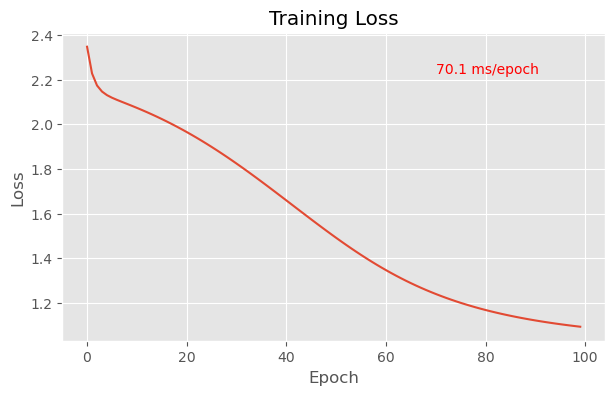

In [8]:
plt.figure(figsize = (7,4))
plt.style.use("ggplot")
plt.plot(np.arange(total_epochs), loss_history)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.text(total_epochs*.7, max(loss_history)*.95,
         f"{round((end_time - start_time)/total_epochs*1000,1)} ms/epoch",
         color = "red",)
plt.show()

In [9]:
#showing updated predictions after training

for i in range(10):
    print("-"*45)    
    print("in, out:\n", x[i].round(2), ",", y[i].round(2), 
          "\n\npredicted:\n", test_net.predict(x[i]).flatten().round(2))

---------------------------------------------
in, out:
 [ 0.89 -0.83] , [-0.74  0.05] 

predicted:
 [-0.08  0.17]
---------------------------------------------
in, out:
 [1.67 0.86] , [1.43 2.53] 

predicted:
 [-0.18  1.62]
---------------------------------------------
in, out:
 [ 0.17 -1.43] , [-0.24 -1.26] 

predicted:
 [ 0.19 -1.35]
---------------------------------------------
in, out:
 [-0.51  0.7 ] , [-0.35  0.19] 

predicted:
 [0.02 0.58]
---------------------------------------------
in, out:
 [-0.23 -0.26] , [ 0.06 -0.5 ] 

predicted:
 [ 0.12 -0.59]
---------------------------------------------
in, out:
 [0.47 0.05] , [0.02 0.52] 

predicted:
 [-0.11  0.85]
---------------------------------------------
in, out:
 [0.6 0.4] , [0.24 1.01] 

predicted:
 [-0.15  1.27]
---------------------------------------------
in, out:
 [1.22 0.09] , [0.11 1.31] 

predicted:
 [-0.2   1.31]
---------------------------------------------
in, out:
 [ 1.63 -0.72] , [-1.18  0.91] 

predicted:
 [-0.23  